# Exp6: 基于集成学习的 Amazon 用户评论质量预测

## 一、案例简介

随着电商平台的兴起，以及疫情的持续影响，线上购物在我们的日常生活中扮演着越来越重要的角色。在进行线上商品挑选时，评论往往是我们十分关注的一个方面。然而目前电商网站的评论质量参差不齐，甚至有水军刷好评或者恶意差评的情况出现，严重影响了顾客的购物体验。因此，对于评论质量的预测成为电商平台越来越关注的话题，如果能自动对评论质量进行评估，就能根据预测结果避免展现低质量的评论。本案例中我们将基于集成学习的方法对 Amazon 现实场景中的评论质量进行预测。

## 二、作业说明

本案例中需要大家完成两种集成学习算法的实现（Bagging、AdaBoost.M1），其中基分类器要求使用 SVM 和决策树两种，因此，一共需要对比四组结果（[AUC](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) 作为评价指标）：

* Bagging + SVM
* Bagging + 决策树
* AdaBoost.M1 + SVM
* AdaBoost.M1 + 决策树

注意集成学习的核心算法需要**手动进行实现**，基分类器可以调库。

### 基本要求
* 根据数据格式设计特征的表示
* 汇报不同组合下得到的 AUC
* 结合不同集成学习算法的特点分析结果之间的差异
* （使用 sklearn 等第三方库的集成学习算法会酌情扣分）

### 扩展要求
* 尝试其他基分类器（如 k-NN、朴素贝叶斯）
* 分析不同特征的影响
* 分析集成学习算法参数的影响

## 三、数据概览

In [122]:
import numpy as np
import pandas as pd 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn import calibration
from scipy import sparse
import random
import math
import tqdm
import itertools



RANDOM_SEED = 20250720

In [123]:
train_df = pd.read_csv('./data/train.csv', sep='\t')

train_df

,reviewerID,asin,reviewText,overall,votes_up,votes_all,label
0,7885,3901,"First off, allow me to correct a common mistak...",5.0,6,7,0
1,52087,47978,I am really troubled by this Story and Enterta...,3.0,99,134,0
2,5701,3667,A near-perfect film version of a downright glo...,4.0,14,14,1
3,47191,40892,Keep your expectations low. Really really low...,1.0,4,7,0
4,40957,15367,"""they dont make em like this no more...""well.....",5.0,3,6,0
...,...,...,...,...,...,...,...
57034,58315,29374,"If you like beautifully shot, well acted films...",2.0,12,21,0
57035,23328,45548,This is a great set of films Wayne did Fox and...,5.0,15,18,0
57036,27203,42453,It's what's known as a comedy of manners. It's...,3.0,4,5,0
57037,33992,44891,Ellen can do no wrong as far a creating wonder...,5.0,4,5,0


本次数据来源于 Amazon 电商平台，包含超过 50,000 条用户在购买商品后留下的评论，各列的含义如下：

* reviewerID：用户 ID
* asin：商品 ID
* reviewText：英文评论文本
* overall：用户对商品的打分（1-5）
* votes_up：认为评论有用的点赞数（只在训练集出现）
* votes_all：该评论得到的总评价数（只在训练集出现）
* label：评论质量的 label，1 表示高质量，0 表示低质量（只在训练集出现）

评论质量的 label 来自于其他用户对评论的 votes，votes_up/votes_all ≥ 0.9 的作为高质量评论。此外测试集包含一个额外的列 ID，标识了每一个测试的样例。

## 四、实验内容

#### 1. 数据处理

In [124]:
test_feature_df = pd.read_csv('./data/test.csv', sep='\t')
test_label_df = pd.read_csv('./groundTruth.csv', sep=',')

# 评论长度特征
train_df['review_word_count'] = train_df['reviewText'].apply(lambda x: len(x.split()))
test_feature_df['review_word_count'] = test_feature_df['reviewText'].apply(lambda x: len(x.split()))

# 拆分训练数据标签和特征
test_df = test_feature_df.merge(test_label_df)


In [125]:
train_df.describe()

,reviewerID,asin,overall,votes_up,votes_all,label,review_word_count
count,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000
mean,33359.761865,19973.170866,3.535178,12.387594,18.475850,0.226196,250.734340
std,30016.804127,14104.410152,1.529742,45.130499,50.149683,0.418371,238.941339
min,50.000000,0.000000,1.000000,0.000000,5.000000,0.000000,1.000000
25%,9235.000000,8218.000000,2.000000,4.000000,6.000000,0.000000,98.000000
50%,22589.000000,17635.000000,4.000000,6.000000,10.000000,0.000000,183.000000
75%,53170.000000,30875.000000,5.000000,11.000000,18.000000,0.000000,319.000000
max,123767.000000,50051.000000,5.000000,6084.000000,6510.000000,1.000000,4319.000000


In [126]:
# 向量化特征
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_vector = vectorizer.fit_transform(train_df['reviewText']).toarray()
# 使用相同的 vectorizer 来转换测试数据，不要重新 fit
X_test_vector = vectorizer.transform(test_df['reviewText']).toarray()
print(X_train_vector.shape, X_test_vector.shape)


(57039, 1000) (11208, 1000)


In [127]:

# 拆分训练数据标签和特征
Y_train = train_df['label']
Y_test = test_df['Expected']
X_train = np.concatenate([X_train_vector,train_df[['review_word_count']]], axis=1)
X_train = MinMaxScaler().fit_transform(X_train)
X_test = np.concatenate([X_test_vector, test_df[['review_word_count']]], axis=1)
X_test = MinMaxScaler().fit_transform(X_test)

#### 2. 模型构建

In [128]:
# bagging

def my_bagging(base_estimators, datas, n_estimators=30, max_samples=0.05, max_features=1.0):
    results, labels, weights = [], [], []
    s0, s1 = datas[0].shape[0], datas[0].shape[1]
    for model in base_estimators:
        for i in range(n_estimators):
            sample_lst = random.sample(range(s0), int(max_samples*s0))
            features_lst = random.sample(range(s1), int(max_features*s1))
            model.fit(datas[0][sample_lst, :]
                    [:, features_lst], datas[1][sample_lst])
            pre = np.array(
                [p[1] for p in model.predict_proba(datas[2][:, features_lst])])
            results.append(pre)
            th = np.sort(pre)[int(0.85*pre.shape[0])]
            pre[pre > th], pre[pre <= th] = 1, 0
            labels.append(pre)
            weights.append([accuracy_score(pre, datas[3])])
    return results, labels, weights

# adaboost
def my_adaboost(base_estimator, datas, n_estimators=30, learning_rate=1.0, algorithm='SAMME.R', max_samples=0.05, max_features=1.0):
    results, labels, weights = [], [], []
    s0, s1 = datas[0].shape[0], datas[0].shape[1]
    model = base_estimator
    prob = np.array([1/s0 for n in range(s0)])
    for i in range(n_estimators):
        sample_lst = random.choices(
            range(s0), weights=prob, k=int(max_samples*s0))
        features_lst = random.sample(range(s1), int(max_features*s1))
        model.fit(datas[0][sample_lst, :][:, features_lst], datas[1][sample_lst])
        mis_lst = np.array(model.predict(datas[0][sample_lst, :][:, features_lst])) ^ datas[1][sample_lst]
        err = np.sum(prob[sample_lst][mis_lst==1])
        if err>0.5:
            print('ignore err > 0.5')
            break
        prob[sample_lst][mis_lst == 1] *= learning_rate*err/(1-err)
        prob/=np.sum(prob)
        pre = np.array([p[1] for p in model.predict_proba(datas[2][:, features_lst])])
        results.append(pre)
        # 根据比例生成预测标签，而不是根据预测概率
        th = np.sort(pre)[int(0.8*pre.shape[0])]
        pre[pre > th], pre[pre <= th] = 1, 0
        labels.append(pre)
        weights.append(1/2*math.log((1-err)/err))
    return results, labels, weights


In [129]:
from sklearn import calibration, svm
# 分类器
classifiers = {
    'svm': calibration.CalibratedClassifierCV(svm.LinearSVC(loss='squared_hinge', dual=False)),
    'decision_tree': DecisionTreeClassifier(max_depth=5),
}

In [130]:
import matplotlib.pyplot as plt
from sklearn import metrics
def weight(results, labels, weights, y, cls_name):
    """
    results: proba of each predict (base model)
    labels: label of each predict (base model)
    weights: weight (accuracy, f(e)...) of each predict (base model)
    
    """
    results, labels, weights = np.array(results).T, np.array(labels).T, np.array(weights)
    fig = plt.figure(figsize=(5, 5))
    
    pre = np.dot(results, weights)/np.sum(weights)
    # 绘图
    fpr, tpr, thresholds = metrics.roc_curve(y, pre, pos_label=1)
    plt.plot(fpr, tpr, lw=2)
    auc = metrics.auc(fpr, tpr)
    pre[pre >= 0.5], pre[pre < 0.5] = 1, 0
    acc = accuracy_score(pre, y)
    plt.title(' Auc: %.2f    Acc: %.2f' % ( auc, acc))
        # print('Method: %s    Auc: %.2f    Acc: %.2f' % (method, auc, acc))
    plt.suptitle('Classifier: '+str(cls_name))

In [131]:
les = np.where(train_df['votes_all'] < 16)[0]
mor = np.where(train_df['votes_all'] >= 16)[0]

##### 1. bagging 效果

100%|██████████| 2/2 [00:09<00:00,  4.90s/it]


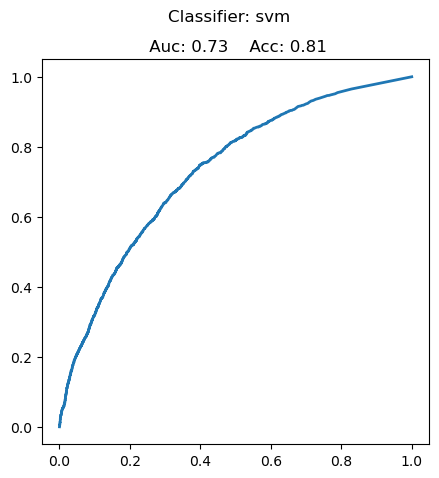

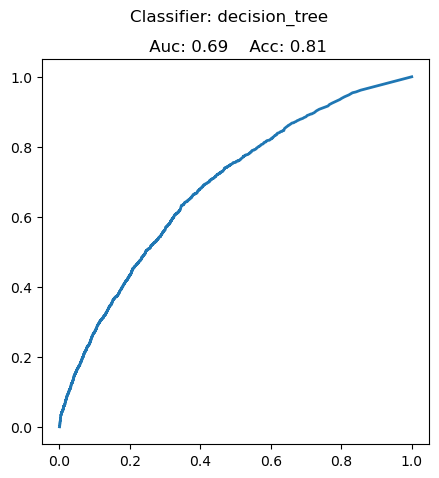

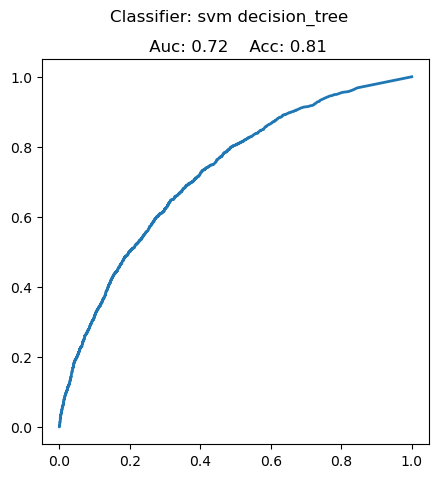

In [142]:
for n in tqdm.tqdm(range(1, len(classifiers)+1)):
    for names in itertools.combinations(classifiers.keys(), n):
        models = [classifiers[name] for name in names]
        # 使用 .iloc 进行位置索引，避免 pandas Series 索引错误
        results, labels, weights = my_bagging(models, datas=[X_train[les], np.array(Y_train.iloc[les]), X_test, Y_test], n_estimators=16//n, max_samples=0.06, max_features=0.6)
        results_mor, labels_mor, weights_mor = my_bagging(models, datas=[X_train[mor], np.array(Y_train.iloc[mor]), X_test, Y_test], n_estimators=16//n, max_samples=0.02, max_features=0.6)
        results+=results_mor
        labels+=labels_mor
        weights+=weights_mor
        weight(results, labels, weights, Y_test, ' '.join(names))

##### 2. adaboost 效果

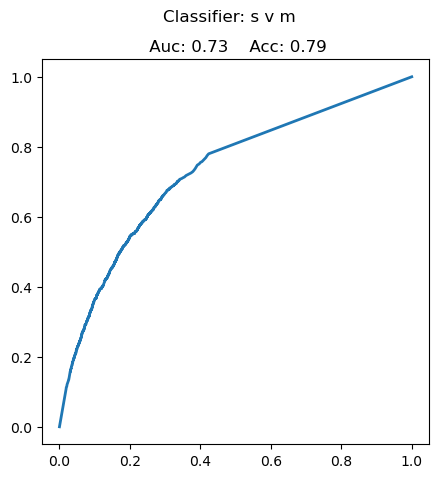

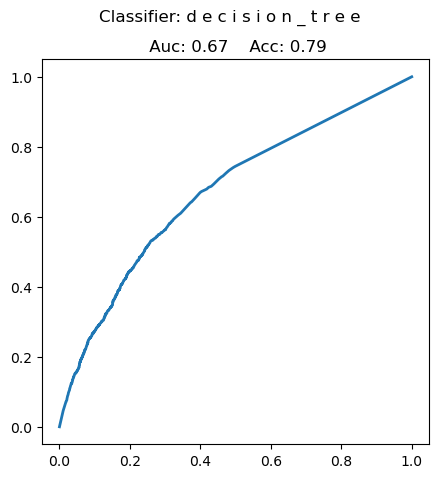

In [133]:
for name, model in classifiers.items():
    results, labels, weights = my_adaboost(model, datas=[X_train[les], np.array(Y_train.iloc[les]), X_test, Y_test], n_estimators=10, max_samples=1.0, max_features=1.0)
    results_mor, labels_mor, weights_mor = my_adaboost(model, datas=[X_train[mor], np.array(Y_train.iloc[mor]), X_test, Y_test], n_estimators=10, max_samples=1.0, max_features=1.0)
    results+=results_mor
    labels+=labels_mor
    weights+=weights_mor
    weight(results, labels, weights, Y_test, ' '.join(name))

#### 3. 实验总结

特征分析：
1. 特征选取上，对于直觉，评论长度可能是一个评判标准。
2. 评论的评价数（vote_all）是一个比较关键的参数，通过这个参数将评价的准确性进行分别采样

AUC分析：
bagging和adaboost的AUC结果如上图
准确率上 bagging 要好于 adaboost，且AUC都能达到近0.7，也验证了bagging总是有效的。